<a href="https://colab.research.google.com/github/Gan4x4/CV-HSE2019/blob/master/extra/YOLACT_get_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/dbolya/yolact.git

Cloning into 'yolact'...
remote: Enumerating objects: 2929, done.
remote: Total 2929 (delta 0), reused 0 (delta 0), pack-reused 2929
Receiving objects: 100% (2929/2929), 21.19 MiB | 29.13 MiB/s, done.
Resolving deltas: 100% (1997/1997), done.


--2020-04-10 09:20:36--  https://github.com/Gan4x4/CV-HSE2019/raw/master/data/yolact_bike.jpeg
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/Gan4x4/CV-HSE2019/master/data/yolact_bike.jpeg [following]
--2020-04-10 09:20:37--  https://media.githubusercontent.com/media/Gan4x4/CV-HSE2019/master/data/yolact_bike.jpeg
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241422 (236K) [image/jpeg]
Saving to: ‘/content/bike.jpg’

/content/bike.jpg   100%[===================>] 235.76K  --.-KB/s    in 0.1s    

2020-04-10 09:20:38 (2.32 MB/s) - ‘/content/bike.jpg’ saved [241422/241422]



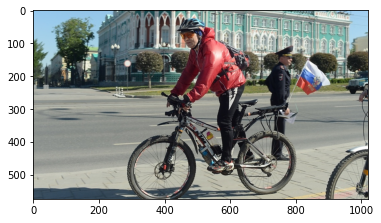

In [1]:
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
! wget -O "/content/bike.jpg" https://github.com/Gan4x4/CV-HSE2019/raw/master/data/yolact_bike.jpeg
pil_image = Image.open("/content/bike.jpg")
imshow(pil_image)

In [0]:


!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yp7ZbbDwvMiFJEq4ptVKTYTI2VeRDXl0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yp7ZbbDwvMiFJEq4ptVKTYTI2VeRDXl0" -O yolact/yolact_resnet50_54_800000.pth && rm -rf /tmp/cookies.txt

--2020-03-27 09:02:47--  https://docs.google.com/uc?export=download&confirm=osXQ&id=1yp7ZbbDwvMiFJEq4ptVKTYTI2VeRDXl0
Resolving docs.google.com (docs.google.com)... 172.217.214.102, 172.217.214.101, 172.217.214.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/k88s0rn88tib02i7dpmua9rpjc3ndl2t/5tvlli8csirhb7bge17q3jrc0e5vptee/1585299750000/02936613423563617570/01589157940911620695Z/1yp7ZbbDwvMiFJEq4ptVKTYTI2VeRDXl0?e=download [following]
--2020-03-27 09:02:47--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/k88s0rn88tib02i7dpmua9rpjc3ndl2t/5tvlli8csirhb7bge17q3jrc0e5vptee/1585299750000/02936613423563617570/01589157940911620695Z/1yp7ZbbDwvMiFJEq4ptVKTYTI2VeRDXl0?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 108.177.111.132, 2607:f8b0:4001:c07::84
Conne

In [0]:
import os
os.chdir('yolact')

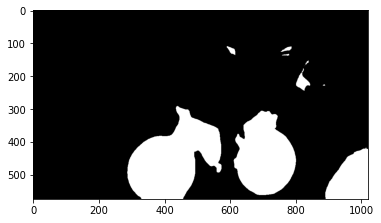

In [0]:
from yolact import Yolact
from torchvision import models, datasets, transforms
from data import cfg, set_cfg
import torch
from data.config import * 
import torch.nn.functional as F
import numpy as np

# Code extracted form yolact/layers/output_utils
def extract_masks(masks,proto_data,w,h):
  masks = proto_data @ masks.t()
  masks = cfg.mask_proto_mask_activation(masks)
  # Permute into the correct output shape [num_dets, proto_h, proto_w]
  masks = masks.permute(2, 0, 1).contiguous()
  masks = F.interpolate(masks.unsqueeze(0), (h, w), mode='bilinear', align_corners=False).squeeze(0)
  # Binarize the masks
  masks.gt_(0.5)
  return masks 

torch.set_default_tensor_type('torch.cuda.FloatTensor')
set_cfg('yolact_resnet50_config')
net = Yolact()
net = net.cuda()
net.load_weights('yolact_resnet50_54_800000.pth')
net.eval()

net.detect.use_fast_nms = True
net.detect.use_cross_class_nms = False
cfg.mask_proto_debug = False

with torch.no_grad():
  transform=transforms.Compose([transforms.ToTensor()])
  tensor_image = transform(pil_image)
  tensor_image =tensor_image.unsqueeze(0)
  batch = tensor_image
  preds = net(batch.cuda())

dets = preds[0]['detection']
classes = dets['class']
boxes   = dets['box']
scores  = dets['score']
masks   = dets['mask']
proto   = dets['proto']

masks = extract_masks(masks,proto,pil_image.size[0],pil_image.size[1])

final = np.zeros((pil_image.size[1],pil_image.size[0]))
for idx,class_num in enumerate(classes): 
  if class_num == 1 and scores[idx] > 0.9:  # bike in COCO
    final += masks[idx].cpu().numpy()
    
im = Image.fromarray(final*255)
imshow(im)

